<a href="https://colab.research.google.com/github/dafarren/Price-and-Inventory-Policy-Model/blob/main/Demand_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerías

In [1]:
# Mis Librerías
!pip install git+https://github.com/dafarren/Price-and-Inventory-Policy-Model.git


  Cloning https://github.com/dafarren/Price-and-Inventory-Policy-Model.git to /tmp/pip-req-build-blwihvse
  Running command git clone --filter=blob:none --quiet https://github.com/dafarren/Price-and-Inventory-Policy-Model.git /tmp/pip-req-build-blwihvse
  Resolved https://github.com/dafarren/Price-and-Inventory-Policy-Model.git to commit a49204ce3f3beefeed6c30928136cff25e2f89c0
  Preparing metadata (setup.py) ... done
  Created wheel for Price-and-Inventory-Policy-Functions: filename=Price_and_Inventory_Policy_Functions-0.1-py3-none-any.whl size=2807 sha256=256c76af2b2010ce2ae8ec801191e65739846a2431e6c97d7b2a3043630f9ad9
  Stored in directory: /tmp/pip-ephem-wheel-cache-0i4a8auc/wheels/f3/a6/0e/c530f6c759e7841eca897d0579010150651679cb2300c91bcb
Successfully built Price-and-Inventory-Policy-Functions


In [2]:
!pip install patchworklib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: mizani
    Found existing installation: mizani 0.13.1
    Uninstalling mizani-0.13.1:
      Successfully uninstalled mizani-0.13.1
  Attempting uninstall: plotnine
    Found existing installation: plotnine 0.14.5
    Uninstalling plotnine-0.14.5:
      Successfully uninstalled plotnine-0.14.5


In [3]:
!pip install prophet

In [1]:
# Liberías
import numpy as np
import matplotlib.pyplot as plt
from my_functions import generar_series_sintetica
import pandas as pd
import seaborn as sns
import patchworklib as pw
from prophet import Prophet
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from plotnine import *

<Figure size 100x100 with 0 Axes>

# Generación y Visualización de Datos

In [2]:
# Generar datos sintéticos
df = generar_series_sintetica(
    n_weeks=52*5,
    start_date='2020-01-01',
    precio_base=50,
    demanda_base=200,
    tendencia_precio_coef=0,
    tendencia_demanda_coef=0.5,
    amplitude_estacionalidad_precio=0,
    amplitude_estacionalidad_demanda=10,
    sigma_precio=2,
    sigma_demanda=5,
    elasticidad=-1.5,
    periodo_estacional=26,
    seed=42,
    plot=False
    )
df = df.reset_index()
print(df.head())

       Fecha     Precio     Demanda
0 2020-01-05  50.993428  199.258662
1 2020-01-12  49.723471  211.667793
2 2020-01-19  51.295377  185.749346
3 2020-01-26  53.046060  186.123309
4 2020-02-02  49.531693  209.370091


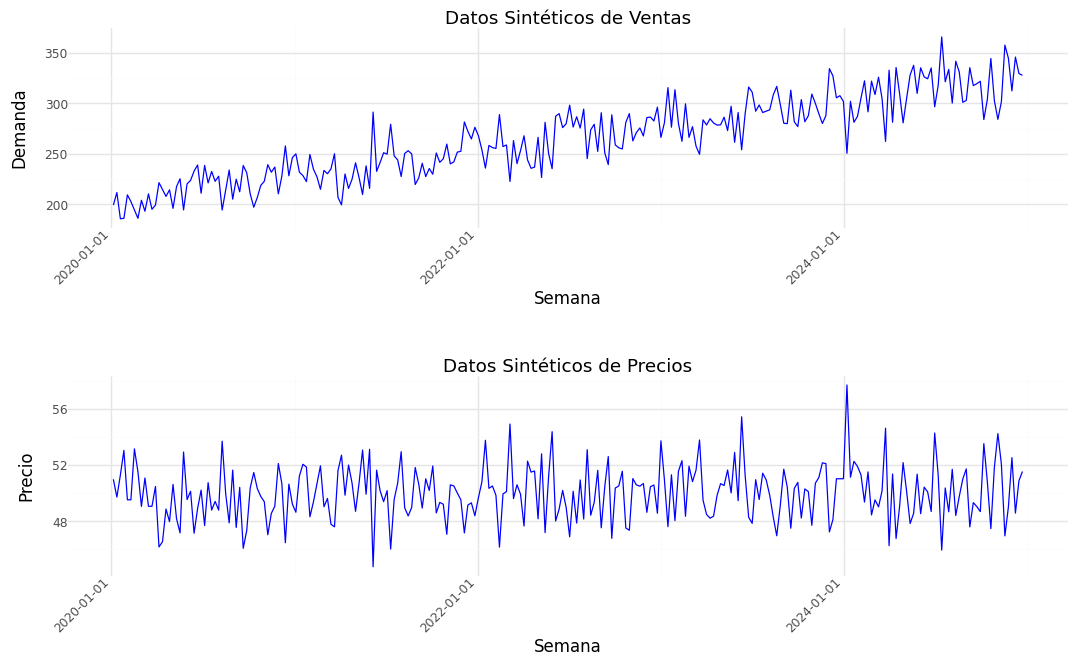

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [3]:
# Asegurarse de que la columna 'Fecha' esté en el DataFrame (se resetea el índice)
df_plot = df.reset_index()

# Crear la visualización con plotnine (estilo ggplot2)
g1 = (
    ggplot(df_plot, aes(x='Fecha', y='Demanda'))
    + geom_line(color='blue')  # Línea de color azul
    + labs(
        title='Datos Sintéticos de Ventas',
        x='Semana',  # Etiqueta más descriptiva para el eje x
        y='Demanda'
      )
    + theme_minimal()  # Tema minimalista de ggplot2
    + theme(axis_text_x=element_text(rotation=45, hjust=1))  # Rotar etiquetas del eje x para mejor legibilidad
)

# Crear la visualización con plotnine (estilo ggplot2)
g2 = (
    ggplot(df_plot, aes(x='Fecha', y='Precio'))
    + geom_line(color='blue')  # Línea de color azul
    + labs(
        title='Datos Sintéticos de Precios',
        x='Semana',  # Etiqueta más descriptiva para el eje x
        y='Precio'
      )
    + theme_minimal()  # Tema minimalista de ggplot2
    + theme(axis_text_x=element_text(rotation=45, hjust=1))  # Rotar etiquetas del eje x para mejor legibilidad
)

g1 = pw.load_ggplot(g1, figsize=(10,2))
g2 = pw.load_ggplot(g2, figsize=(10,2))

g12 = (g1/g2)
g12.savefig()


# Modelo de Demanda

In [4]:
# Modelado con Prophet
df_prophet = df.rename(columns={'Fecha': 'ds', 'Demanda': 'y'})
prophet_model = Prophet(interval_width=0.95)
prophet_model.add_regressor('Precio')
prophet_model.fit(df_prophet)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpttgyz7dz/agmj3vyx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpttgyz7dz/d02bm8lr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77163', 'data', 'file=/tmp/tmpttgyz7dz/agmj3vyx.json', 'init=/tmp/tmpttgyz7dz/d02bm8lr.json', 'output', 'file=/tmp/tmpttgyz7dz/prophet_modelzwvu8azd/prophet_model-20250204120535.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:05:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:05:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [5]:
# Evaluación del modelo
forecast_train = prophet_model.predict(df_prophet)
y_true = df_prophet['y']
y_pred = forecast_train['yhat']
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, R²: {r2:.2f}")


MAE: 3.80, MSE: 23.88, R²: 0.98


In [6]:
# Calcular Elasticidad Precio de la Demanda (EPD) a partir de los datos
log_prices = np.log(df_prophet['Precio'])
log_sales = np.log(df_prophet['y'])
X = sm.add_constant(log_prices)
model = sm.OLS(log_sales, X).fit()
calculated_elasticity = model.params['Precio']
print(f"Elasticidad Precio de la Demanda Estimada: {calculated_elasticity:.2f}")
print(model.summary())


Elasticidad Precio de la Demanda Estimada: -1.08
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     20.99
Date:                Tue, 04 Feb 2025   Prob (F-statistic):           7.21e-06
Time:                        12:05:47   Log-Likelihood:                 130.70
No. Observations:                 260   AIC:                            -257.4
Df Residuals:                     258   BIC:                            -250.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
con

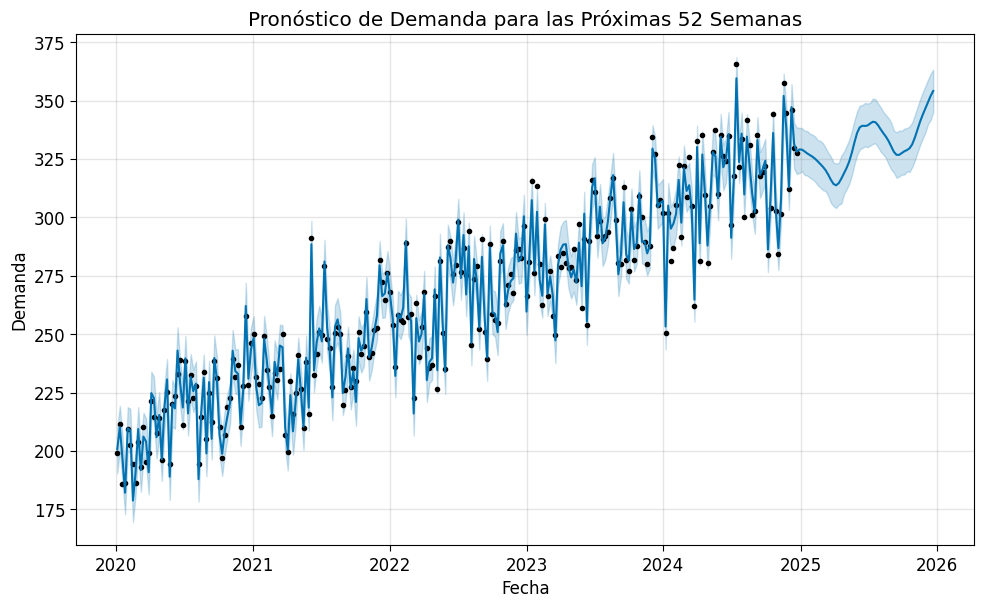

In [24]:
# Crear un DataFrame futuro para 52 semanas (frecuencia semanal)
future = prophet_model.make_future_dataframe(periods=52, freq='W')

# Precio Futuro
future['Precio'] = df['Precio'].tolist()+[df['Precio'].iloc[-1]]*52

# Realizar la predicción con el DataFrame 'future' que ahora contiene la columna 'Precio' correcta
forecast = prophet_model.predict(future)

# Visualizar el pronóstico con el gráfico de Prophet
fig1 = prophet_model.plot(forecast)
plt.title("Pronóstico de Demanda para las Próximas 52 Semanas")
plt.xlabel("Fecha")
plt.ylabel("Demanda")
plt.show()



# Simulación Demanda

In [40]:
# Simulación de demanda proyectada con Prophet
def simulate_demand(model, future, simulations=500):
    future_only = future.iloc[-52:].copy()
    simulations_results = np.zeros((simulations, len(future_only)))
    for i in range(simulations):
        forecast_sim = model.predict(future_only)['yhat'] + np.random.normal(scale=5, size=len(future_only))
        simulations_results[i, :] = forecast_sim
    return simulations_results

simulated_demand = simulate_demand(prophet_model, future, simulations=100)




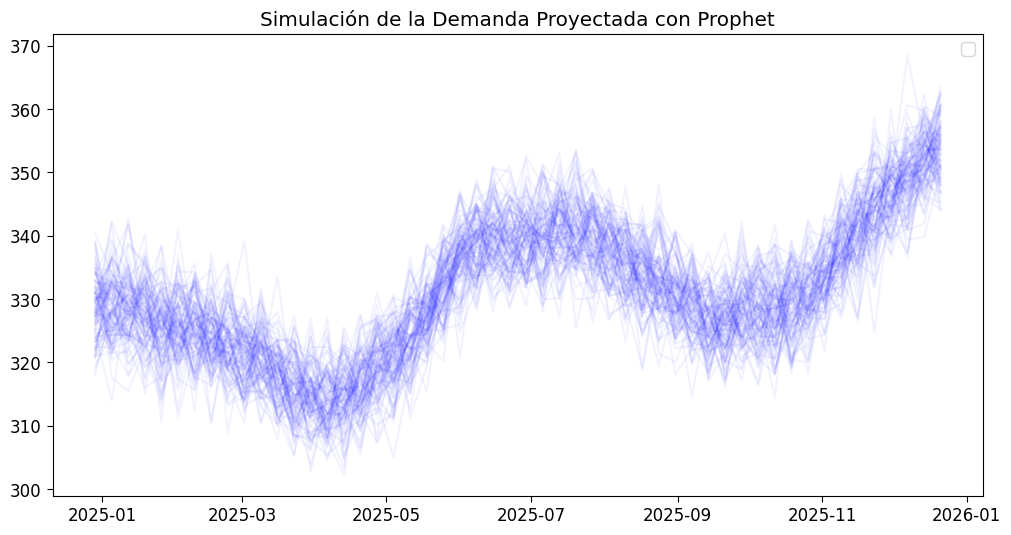

In [41]:
# Visualización de simulaciones
plt.figure(figsize=(12, 6))
plt.plot(future_only['ds'], simulated_demand.T, alpha=0.05, color='blue')
plt.title("Simulación de la Demanda Proyectada con Prophet")
plt.legend()
plt.show()